In [103]:
# first compute all the kernel derivatives
import sympy as sym

x = sym.Symbol('x')
xp = sym.Symbol('xp')
L = sym.Symbol('L')

kernel = sym.exp(-0.5 / L / L * (x - xp)**2)
print(f"{kernel=}")

lapl2_kernel = kernel.diff(x, x)
print(f"{lapl2_kernel=}")

lapl4_kernel = kernel.diff(x, x, x, x)
print(f"{lapl4_kernel=}")

lapl6_kernel = kernel.diff(x, x, x, x, xp, xp)
print(f"{lapl6_kernel=}")

lapl8_kernel = kernel.diff(x, x, x, x, xp, xp, xp, xp)
print(f"{lapl8_kernel=}")

kernel=exp(-0.5*(x - xp)**2/L**2)
lapl2_kernel=1.0*(-1 + (x - xp)**2/L**2)*exp(-0.5*(x - xp)**2/L**2)/L**2
lapl4_kernel=(3.0 - 6.0*(x - xp)**2/L**2 + 1.0*(x - xp)**4/L**4)*exp(-0.5*(x - xp)**2/L**2)/L**4
lapl6_kernel=(-15.0 + 45.0*(x - xp)**2/L**2 - 15.0*(x - xp)**4/L**4 + 1.0*(x - xp)**6/L**6)*exp(-0.5*(x - xp)**2/L**2)/L**6
lapl8_kernel=(105.0 - 420.0*(x - xp)**2/L**2 + 210.0*(x - xp)**4/L**4 - 28.0*(x - xp)**6/L**6 + 1.0*(x - xp)**8/L**8)*exp(-0.5*(x - xp)**2/L**2)/L**8


Or in other words, if in 2D kernel k(x,x') = k_x * k_y we have in each 1D direction:
$$ k_x = exp(-1/2 * \frac{(x-x')^2}{L_x^2}) = exp(-0.5 \overline{x}^2) $$
where $\overline{x} = (x-x')/L_x$.
Then the derivative of this 1D kernel are from above:
$$ k_x = exp(-1/2 \cdot \overline{x}^2) $$
$$ \partial_x^2 k_x = L_x^{-2} (-1 + \overline{x}^2) k_x $$
$$ \partial_x^4 k_x = L_x^{-4} (3 -6 \overline{x}^2 + \overline{x}^4) k_x $$

So in 2D if $K = k_x \cdot k_y$ then we have the following Laplacian:
$$ \nabla_x^4 K = \partial_x^4 k_x k_y + 2 \partial_x^2 k_x \partial_y^2 k_y + \partial_y^4 k_y $$

# Optimization problem in RKHS (Reproducing Kernel Hilbert Space)
Now we have the discrete kernel function $K(x,x')$ certainly, but in function space there is also an inner product on the kernel $K$ which is:
$$ <\phi, \psi>_K = \int K(x,x') \phi(x) \psi(x') dx dx' $$
The norm in the RKHS of a function w(x) is also:
$$ |w(x)|_K = \sqrt{<w, Kw>} = \sqrt{\int K(x,x') w(x) w(x') dx dx'} $$
More details included in the overleaf. Going to proceed into doing the analysis and constructing the kernel matrix.

In [104]:
# panel linear static inputs
# buckling inputs
# ----------------

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)

# choose loading type (first just uniaxial loading in x-direction)
# axial = True
axial = True
if axial:
    Nxx, Nxy, Nyy = (1e3, 0, 0)
else:
    Nxx, Nxy, Nyy = (0, 1e2, 0)

# a, b = (1, 1)
(a, b) = (3, 1)

def q_load(x,y): # distributed load across the panel
    return 1.0

type(x_train)=<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


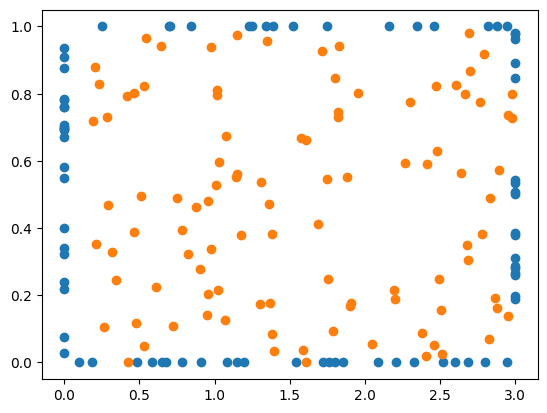

In [105]:
# compute the linear static analysis inputs and mesh domain of collocation pts
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# num_domain = 1000
# need lower numbers first since this is a dense matrix..
num_domain = 100
num_bndry = 40
num_test = 50

num_interior = num_domain



DTYPE = tf.float32

# set the boundary of the panel
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# generate the collocation points on the interior
def gen_collocation_points(num_domain, minval, maxval):
    x_r = tf.random.uniform((num_domain,1), minval[0], maxval[0], dtype=DTYPE)
    y_r = tf.random.uniform((num_domain,1), minval[1], maxval[1], dtype=DTYPE)
    X_r = tf.concat([x_r, y_r], axis=1)
    # data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
    # return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)
    return tf.Variable(X_r, dtype=DTYPE)

x_train = gen_collocation_points(num_domain, lb, ub)
x_test = gen_collocation_points(num_test, lb, ub)
print(f"{type(x_train)=}")

x = x_train[:,0:1]
y = x_train[:,1:2]

x2 = x_test[:,0:1]
y2 = x_test[:,1:2]

# generate boundary domain points
N_b = num_bndry
x_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b1 = tf.concat([x_b1, y_b1], axis=1)

# boundary data on x edges
y_b2 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
# print(f"{x_b2=}")
X_b2 = tf.concat([x_b2, y_b2], axis=1)
# print(f"{X_b2=}")
# print(f"{x_b2=}")

x_bndry = tf.Variable(tf.concat([X_b1, X_b2], axis=0), dtype=DTYPE)

# plot the data to check
plt.scatter(x_bndry[:,0], x_bndry[:,1])
plt.scatter(x_train[:,0], x_train[:,1]) # only show 1000 of the points
plt.show()

# q vector
_temp = np.array([q_load(x[i], y[i]) for i in range(num_domain)])
q = tf.constant(_temp, shape=(num_domain,1), dtype=DTYPE)

In [106]:
# compute the block matrix Sigma = [cov(w_int, w_int), cov(w_int, w_bndry), cov(w_int, nabla^4 w_int),
#                                   cov(w_bndry, w_int), cov(w_bndry, w_bndry), cov(w_bndry, nabla^4 w_bndry),
#                                   cov(nabla^4 w_int, w_int), cov(nabla^4 w_int, w_bndry), cov(nabla^4 w_int, nabla^4 w_int) ]
# not a function of theta..
import tensorflow as tf
import numpy as np

theta_arr = tf.zeros(shape=(num_domain,1), dtype=DTYPE)
theta = tf.Variable(theta_arr, trainable=True, dtype=DTYPE)
# print(f"{theta=}")

# hyperparameter here (could include in optimization as well later)
Lx = 1.0
Ly = 1.0

# compute block matrix now
def kernel1d(x,xp,L):
    xbar = (x - xp) / L
    return np.exp(-0.5 * xbar**2)

def kernel1d_d2(x,xp,L):
    xbar = (x-xp)/L
    return L**(-2.0) * (-1.0 + xbar**2) * kernel1d(x,xp,L)

def kernel1d_d4(x,xp,L):
    xbar = (x-xp)/L
    return L**(-4.0) * (3.0 - 6.0 * xbar**2 + xbar**4) * kernel1d(x,xp,L)

def kernel1d_d6(x,xp,L):
    xbar = (x-xp)/L
    return L**(-6.0) * (105 - 420 * xbar**2 + 210 * xbar**4 - 28 * xbar**6 + xbar**8) * kernel1d(x,xp,L)

def kernel1d_d8(x,xp,L):
    xbar = (x-xp)/L
    return L**(-8.0) * (105 - 420 * xbar**2 + 210 * xbar**4 - 28 * xbar**6 + xbar**8) * kernel1d(x,xp,L)

def kernel2d(x,xp):
    return kernel1d(x[0], xp[0], Lx) * kernel1d(x[1], xp[1], Ly)

def kernel2d_lapl(x,xp):
    return kernel1d_d4(x[0], xp[0], Lx) * kernel1d(x[1], xp[1], Ly) + \
           2.0 * kernel1d_d2(x[0], xp[0], Lx) * kernel1d_d2(x[1], xp[1], Ly) + \
           kernel1d(x[0], xp[0], Lx) * kernel1d_d4(x[1], xp[1], Ly)

def kernel2d_double_lapl(x,xp):
    # nabla_x^4 * nabla_x'^4 exapnds into 16 terms
    return kernel1d_d8(x[0], xp[0], Lx) * kernel1d(x[1], xp[1], Ly) + \
           4.0 * kernel1d_d6(x[0], xp[0], Lx) * kernel1d_d2(x[1], xp[1], Ly) + \
           6.0 * kernel1d_d4(x[0], xp[0], Lx) * kernel1d_d4(x[1], xp[1], Ly) + \
           4.0 * kernel1d_d2(x[0], xp[0], Lx) * kernel1d_d6(x[1], xp[1], Ly) + \
           kernel1d(x[0], xp[0], Lx) * kernel1d_d8(x[1], xp[1], Ly)

# def kernel2d_12(x,xp):
#     return kernel1d_d2(x[0], xp[0], Lx) * kernel1d(x[1], xp[1], Ly)

# debugging
# num_interior = 5
# num_bndry = 3
# k31 = kernel2d_lapl(x_train[0,:], x_train[0,:])
# print(f"{k31=}")

n_block = 2 * num_interior + num_bndry
sigma_eye = 1e-11 #1e-13

# 1 - w interior, 2 - w exterior, 3 - nabla^4 w interior
K11 = tf.constant([[kernel2d(x_train[i,:], x_train[j,:]) for i in range(num_interior)] for j in range(num_interior)], dtype=DTYPE)
K21 = tf.constant([[kernel2d(x_train[i,:], x_bndry[j,:]) for i in range(num_interior)] for j in range(num_bndry)], dtype=DTYPE)
# print(f"{K21.shape=}")
K22 = tf.constant([[kernel2d(x_bndry[i,:], x_bndry[j,:]) for i in range(num_bndry)] for j in range(num_bndry)], dtype=DTYPE)
_temp1 = np.array([[kernel2d_lapl(x_train[i,:], x_train[j,:]) for i in range(num_interior)] for j in range(num_interior)])
K31 = tf.constant(_temp1, dtype=DTYPE)
_temp2 = np.array([[kernel2d_lapl(x_bndry[i,:], x_train[j,:]) for i in range(num_bndry)] for j in range(num_interior)])
K32 = tf.constant(_temp2, dtype=DTYPE)
# print(f"{K32.shape=}")
_temp3 = np.array([[kernel2d_double_lapl(x_train[i,:], x_train[j,:]) for i in range(num_interior)] for j in range(num_interior)])
K33 = tf.constant(_temp3, dtype=DTYPE)
# _step1 = tf.concat([K11, K21.T, K31.T], axis=1)
_row1 = tf.concat([K11, tf.transpose(K21), tf.transpose(K31)], axis=1)
_row2 = tf.concat([K21, K22, tf.transpose(K32)], axis=1)
_row3 = tf.concat([K31, K32, K33], axis=1)
# adaptive nugget term added here
Kblock = tf.constant(tf.concat([_row1, _row2, _row3], axis=0) + tf.eye(n_block) * sigma_eye, dtype=DTYPE)
# print(f"{Kblock=}")

In [107]:
# do cholesky decomposition of Kblock = L L^T with constant before we actually do optimization (since this part is fixed and not a part of theta optimization)
# K_chol = tf.linalg.cholesky(Kblock)
K_lu = tf.linalg.lu(Kblock)

# constant vector part [w_{dOmega}, nabla^4 w] where nabla^4 w = -q / D
w_ext = tf.zeros(shape=(num_bndry,1), dtype=DTYPE)
print(f"{w_ext.shape=}")
nabla4_w = -q / D
nabla4_w2 = tf.reshape(nabla4_w, shape=(num_domain,1))
print(f"{nabla4_w2.shape=}")
_temp = tf.concat([w_ext, nabla4_w2], axis=0)
fixed_vec = tf.constant(_temp, dtype=DTYPE)

w_ext.shape=TensorShape([40, 1])
nabla4_w2.shape=TensorShape([100, 1])


In [ ]:
# now optimize the theta parameter of interior w values
theta = tf.Variable(tf.zeros(shape=(num_domain,1), dtype=DTYPE), trainable=True)
# theta = [tf.Variable(t) for t in theta]
# print(f"{theta=}")
num_epochs = 100

learning_rate = 1e-3 # can be much higher here?
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for epoch in range(num_epochs):
    # record the loss gradient
    with tf.GradientTape(persistent=True) as tape:
        w_full = tf.concat([theta, fixed_vec], axis=0)
        ans = tf.linalg.lu_solve(*K_lu, rhs=w_full)
        # print(f"{ans=}")
        # print(f"{w_full=}")
        # how is this value negative? Is it because I have covariance matrix is wrong so K_block is negative definite?
        loss = tf.tensordot(tf.transpose(w_full), ans, axes=1)
        print(f"{loss=}")
        # print(f"{loss.shape=}")

    loss_gradient = tape.gradient(loss, theta)
    # print(f"{loss_gradient=}")

    # could change to Gauss-newton algorithm here instead.. would prob be better

    # gradient descent with adam optimizer
    optimizer.apply_gradients(
        [(loss_gradient, theta)]
    )
    del tape

    loss_val = loss.numpy()[0,0]
    print(f"{epoch=}\t{loss_val=}")

# print(f"{theta=}")

loss=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-6.20048e-07]], dtype=float32)>
epoch=0	loss_val=-6.20048e-07
loss=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-3169.5928]], dtype=float32)>
epoch=1	loss_val=-3169.5928
loss=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-14138.733]], dtype=float32)>
epoch=2	loss_val=-14138.733
loss=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-32604.064]], dtype=float32)>
epoch=3	loss_val=-32604.064
loss=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-61229.17]], dtype=float32)>
epoch=4	loss_val=-61229.17
loss=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-105484.47]], dtype=float32)>
epoch=5	loss_val=-105484.47
loss=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-155361.89]], dtype=float32)>
epoch=6	loss_val=-155361.89
loss=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-219660.75]], dtype=float32)>
epoch=7	loss_val=-219660.75
loss=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=ar

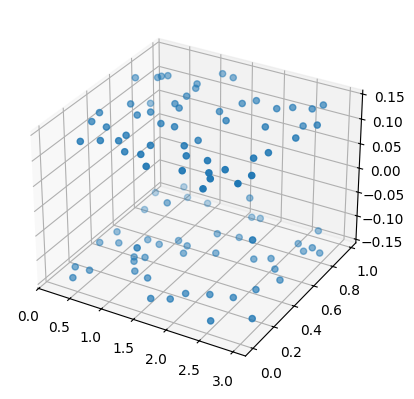

In [ ]:
# plot the deflections now
import matplotlib.pyplot as plt
import numpy as np

def plot_mode(n=50):
    # x_vec = np.linspace(0, a, n)
    # y_vec = np.linspace(0, b, n)
    # X, Y = np.meshgrid(x_vec, y_vec)
    # x_flat = np.reshape(X, newshape=(n*n,1))
    # y_flat = np.reshape(Y, newshape=(n*n,1))
    
    # # predict the model at each of these points
    # grid_inputs = np.concatenate([x_flat, y_flat], axis=1)

    # w = model(grid_inputs)
    # W = np.reshape(w, newshape=(n,n))

    # # plt.figure(figsize=(8, 6))
    # # colors = plt.contourf(X, Y, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
    # # plt.colorbar(colors, label="w(x,y)")  # Colorbar for reference

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # surface = ax.plot_surface(X, Y, W, cmap='viridis')

    # plt.xlabel("X-axis")
    # plt.ylabel("Y-axis")
    # # plt.title("2D Contour Plot")
    # plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, theta)
    plt.show()

plot_mode()